## NLP Class Final Project Read Data

# NLP Final Project 1.01: Data Preparation

This notebook serves to:
- download raw data
- pre-clean raw text

## Set-up

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

import warnings
warnings.filterwarnings("ignore")

In [3]:
from pprint import pprint
import re
from tqdm import tqdm
tqdm.pandas()
import numpy as np

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=12, progress_bar=True)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
import os

# Google Bucket
runtime_path = '/home/anthony/projects/nlp_runtime'
path_bucket = 'gs://msca-sp23-bucket/nlp_data'

os.chdir(runtime_path)
print(os.getcwd())

/home/anthony/projects/nlp_runtime


## Read data

In [4]:
#df = pd.read_parquet('news_final_project.parquet', engine='pyarrow')

In [4]:
# %%time
# df_news_final_project = pd.read_parquet('https://storage.googleapis.com/msca-bdp-data-open/news_final_project/news_final_project.parquet', engine='pyarrow')
# df_news_final_project.shape

CPU times: user 8.78 s, sys: 4.52 s, total: 13.3 s
Wall time: 19.4 s


(200332, 5)

In [4]:
# save a copy at bucket
bucket_write = path_bucket + '/' + 'checkpoint_0522_raw_data.parquet'
#df_news_final_project.to_parquet(bucket_write, index=False)

In [6]:
# restart and reload to save RAM
df = pd.read_parquet('gs://msca-sp23-bucket/nlp_data/checkpoint_0522_raw_data.parquet', engine='pyarrow')

## Descriptive Exploration

In [7]:
#df = df.sample(20000, random_state=42)
df.head(5)

,url,date,language,title,text
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,en,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,"\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome>>\n\t\t\nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao (People's Daily) 09:16, Mar..."
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor..."
2,http://www.dataweek.co.za/12835r,2021-03-26,en,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek","\n\nForget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek\nHome\nAbout us\nBack issues / E-book / PDF\nEMP Handbook\nSubscribe\nAdvertise\n\nCategories\n\n▸ Editor's Choice\n▸ Multimedia, Videos\n▸ Analogue, Mixed Signal, LSI\n▸ Circuit & System Protection\n▸ Computer/Embedded Technology\n▸ Design Automation\n▸ DSP, Micros & Memory\n▸ Electronics Technology\n▸ Enclosures, Racks, Cabinets & Panel Products\n▸ Events\n▸ Interc..."
3,http://www.homeoffice.consumerelectronicsnet.com/strategy-analytics-71-of-smartphones-sold-globally-in-2021-will-be-ai-powered/,2021-03-10,en,Strategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Electronics Net,\n\nStrategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered – Consumer Electronics Net\n \nSkip to content\n\nConsumer Electronics Net\n\nPrimary Menu\n\nConsumer Electronics Net\n\nSearch for:\n \nHomeNewsStrategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered \n \n News\n \n \nStrategy Analytics: 71% of Smartphones Sold Globally in 2021 will be AI Powered\n 7 hours...
4,http://www.itbusinessnet.com/2020/10/olympus-to-support-endoscopic-ai-diagnosis-education-for-doctors-in-india-and-to-launch-ai-diagnostic-support-application/?utm_source=rss&utm_medium=rss&utm_campaign=olympus-to-support-endoscopic-ai-diagnosis-education-for-doctors-in-india-and-to-launch-ai-diagnostic-support-application,2020-10-20,en,Olympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application | | IT Business Net,\n\nOlympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application | | IT Business Net\n \nSkip to content\n\nIT Business Net\n\nNews for IT Professionals\nPrimary Menu\n\nIT Business Net\nAbout IT Business Net\n\nSearch for:\n \nHome2020OctoberOlympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application \n \n News\n ...


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200332 entries, 0 to 200331
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   url       200332 non-null  object
 1   date      200332 non-null  object
 2   language  200332 non-null  object
 3   title     200332 non-null  object
 4   text      200332 non-null  object
dtypes: object(5)
memory usage: 7.6+ MB


Series([], dtype: float64)


<Axes: title={'center': "Each column's missing values %"}>

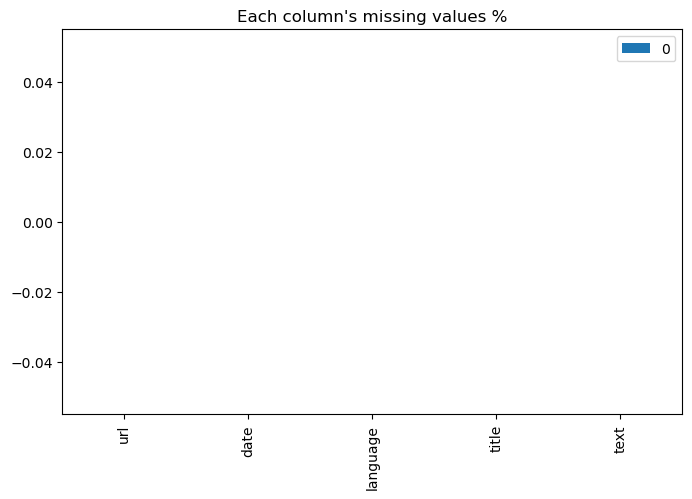

In [9]:
# missing value
print((df.isnull().sum()[df.isnull().sum()/len(df)>0]/len(df)).sort_values(ascending =False))
pd.DataFrame((df.isnull().sum()/len(df)).sort_values(ascending =False)).plot(kind='bar',figsize=(8,5),title='Each column\'s missing values %')

## Text Cleaning

For text cleaning as the proeprocessing, I will:
1. remove html tags & ruls from parsing 
2. split the document (one article) by `\n\n` and reduce length accordingly

In [10]:
# remove URL (started in '//' or be like 'http\S+') and newline (started in '\n') and url
# only keep alphabet, number, and punctuation

df['text_no_url'] = df['text'].parallel_apply(lambda x: re.sub('http\S+|www\S+|\S+.com|https\S+|\S+.htmlSOURCE|\xa0|\t|©|@|\r',' ',x))
df['text_no_url'] = df['text_no_url'].parallel_apply(lambda x: re.sub('[^A-Za-z0-9.,!?/:;\"\'\s]+', ' ',x))

In [11]:
df[['text','text_no_url']].iloc[2:3,:]

,text,text_no_url
2,"\n\nForget ML, AI and Industry 4.0 – obsolescence should be your focus - 26 February 2021 - Test & Rework Solutions - Dataweek\nHome\nAbout us\nBack issues / E-book / PDF\nEMP Handbook\nSubscribe\nAdvertise\n\nCategories\n\n▸ Editor's Choice\n▸ Multimedia, Videos\n▸ Analogue, Mixed Signal, LSI\n▸ Circuit & System Protection\n▸ Computer/Embedded Technology\n▸ Design Automation\n▸ DSP, Micros & Memory\n▸ Electronics Technology\n▸ Enclosures, Racks, Cabinets & Panel Products\n▸ Events\n▸ Interc...","\n\nForget ML, AI and Industry 4.0 obsolescence should be your focus 26 February 2021 Test Rework Solutions Dataweek\nHome\nAbout us\nBack issues / E book / PDF\nEMP Handbook\nSubscribe\nAdvertise\n\nCategories\n\n Editor's Choice\n Multimedia, Videos\n Analogue, Mixed Signal, LSI\n Circuit System Protection\n Computer/Embedded Technology\n Design Automation\n DSP, Micros Memory\n Electronics Technology\n Enclosures, Racks, Cabinets Panel Products\n Events\n Interc..."


In [12]:
# save a record of original text length
df['text_len_initial'] = df['text'].parallel_apply(lambda x: len(x))

## Split sentences (rule-based)

**Notes:**
1. What is the best way to split sentences?
    - rule-based approach
        - `\n\n` sign: paragraphs in new articles normally breaks with two new lines. If we can break the whole document into sentences by `\n\n`, we can select the sentences has the most words as the title of the article.
        - `all rights reserved` sign: this sign is normally at the end of the article. If we can break the whole document into sentences by `all rights reserved`, we can select the sentences before the break word as the content.
    - model-based approach
        - `spacy` sentence tokenizer

In [13]:
# create a new True/False column telling whether each value of column 'text_url' has the string "all rights reserved", case insensitive
df['spilit_check'] = df['text_no_url'].parallel_apply(lambda x: True if re.search('all rights reserved', x, re.IGNORECASE) else False)

In [14]:
df['spilit_check'].value_counts()

spilit_check
False    138619
True      61713
Name: count, dtype: int64

Only about 40% of the articles include "all rights reserved" sign. So we need more filtering rules later.

But let's split the text by `all right reserved` first.

In [15]:
# define a function to split text with "all right reserved" into sentences
def words_split(search_word, input_text):
    if re.search(search_word, input_text, re.IGNORECASE):
        split_list = input_text.split(search_word)
        if len(split_list) <= 2:
            return split_list[0]
        elif len(split_list) > 2: # return everything before the last split
            print('multiple split')
            return split_list[:-1]
        else:
            return 'bug'
    else: # return input if no search_word in input_text
        return input_text

In [16]:
# split text with our function
df['text_split'] = df['text_no_url'].parallel_apply(lambda x: words_split('all rights reserved', x))

In [39]:
'''# debug
test = df.iloc[0,:]['text_no_url']
words_split('all rights reserved', test)
# check results
df[['text_no_url','text_split']]'''

"\n\nArtificial intelligence improves parking efficiency in Chinese cities   People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome \n  \nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao  People's Daily  09:16, March 18, 2021\nPhoto taken on July 1, 2019, shows a sign for electronic toll collection  ETC  newly set up at a roadside parking space on Yangzhuang road, Shijingshan district, Beijing. Some urban areas of the city started to use ETC system for roadside parking spaces since July 1, 2019.  People s Daily Online/Li Wenming \n\n Thanks to the application of an artificial intelligence  AI empowered roadside electronic toll collection  ETC  system, China s capital city Beijing has seen significant improvemen

Note:

2. Now we want to deal with the 138619 obvervations that don't have `all right reserve` as ending phrase. 
    - These articles don't have this term might be that the parsing didn't get the complete article, or they simply didn't have it
    - Either way, we can still spilt the whole text by `\n\n` as a break paragrah and break the text into large trunks
    - Then, we can filter out paragraphes that are less important based on trunk length

In [17]:
# split 'text_sent' by '\n\n'
df['text_split'] = df['text_split'].parallel_apply(lambda x: x.split('\n\n'))

In [26]:
# get the length of each text_split
df['text_split_len'] = df['text_split'].parallel_apply(lambda x: len(x))

In [27]:
df.text_split_len.describe()

count    200332.000000
mean         54.302128
std          92.590373
min           1.000000
25%           2.000000
50%          27.000000
75%          67.000000
max        4314.000000
Name: text_split_len, dtype: float64

<Axes: title={'center': 'Distribution of text_split_len'}, ylabel='Frequency'>

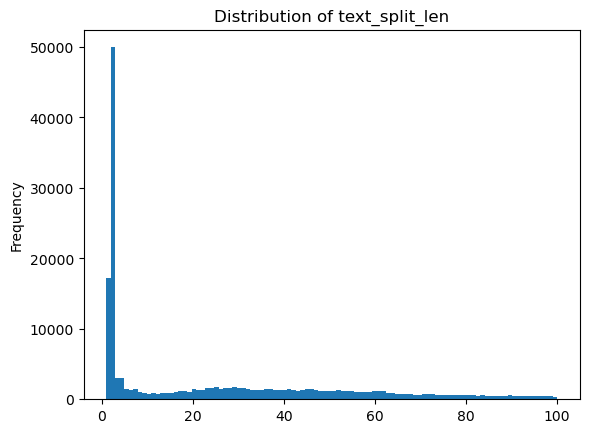

In [28]:
# filter out text_split with length > 100
text_split_len_filtered = df.text_split_len[text_split_len<=100]

# visualize the distribution of text_split_len
text_split_len_filtered.plot(kind='hist', bins=100, title='Distribution of text_split_len')

In [30]:
df.head(2)

,url,date,language,title,text,text_no_url,text_len_initial,spilit_check,text_split,text_split_len
0,http://en.people.cn/n3/2021/0318/c90000-9830122.html,2021-03-18,en,Artificial intelligence improves parking efficiency in Chinese cities - People's Daily Online,"\n\nArtificial intelligence improves parking efficiency in Chinese cities - People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome>>\n\t\t\nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao (People's Daily) 09:16, Mar...","\n\nArtificial intelligence improves parking efficiency in Chinese cities People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome \n \nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao People's Daily 09:16, March ...",5752,True,"[, Artificial intelligence improves parking efficiency in Chinese cities People's Daily Online, Home\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto, Languages, Chinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome \n \nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao People's Daily 09:16, March 18, 202...",20
1,http://newsparliament.com/2020/02/27/children-with-autism-saw-their-learning-and-social-skills-boosted-after-playing-with-this-ai-robot/,2020-02-27,en,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot – News Parliament\n \n\nSkip to content\n\t\t\tThursday, February 27, 2020\t\t\n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in cor...","\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament\n \n\nSkip to content\n Thursday, February 27, 2020 \n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in corporat...",10150,True,"[\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament\n , Skip to content\n Thursday, February 27, 2020 , Latest:, \nMansplaining in conferences: How can we get him to forestall?, \nDrax power station to cease burning coal in March 2021, \nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy, \nCoronavirus: Dettol sales surge as markets fall again, \nLevi Strauss marks the next phase in corporate paid leave ...",60


Now we see a distribution of the number of trunks per observation. 1/4 of the news has less than 2 trunks spilt by `\n\n` and the media length in 27 trunks. We can calculate the average length of the trunks and use it as a threshold to filter out the trunks that have less length.

In [32]:
df.iloc[2, :]['text_split']

['',
 'Forget ML, AI and Industry 4.0   obsolescence should be your focus   26 February 2021   Test   Rework Solutions   Dataweek\nHome\nAbout us\nBack issues / E book / PDF\nEMP Handbook\nSubscribe\nAdvertise',
 'Categories',
 "  Editor's Choice\n  Multimedia, Videos\n  Analogue, Mixed Signal, LSI\n  Circuit   System Protection\n  Computer/Embedded Technology\n  Design Automation\n  DSP, Micros   Memory\n  Electronics Technology\n  Enclosures, Racks, Cabinets   Panel Products\n  Events\n  Interconnection\n  Manufacturing / Production Technology, Hardware   Services\n  News\n  Opto Electronics\n  Passive Components\n  Power Electronics / Power Management\n  Programmable Logic\n  Smart Home Automation\n  Switches, Relays   Keypads\n   s,  s, Wireless, IoT\n  Test   Measurement\n ",
 'Categories',
 "Editor's Choice",
 '\nMultimedia, Videos',
 '\nAnalogue, Mixed Signal, LSI',
 '\nCircuit   System Protection',
 '\nComputer/Embedded Technology',
 '\nDesign Automation',
 '\nDSP, Micros   Mem

### Trunk Cleaning

We see some trunks have less than 5 or 10 words because they used to be tags on the website guide dashboard.

In [5]:
# save checkpoint
ckp_path = '/home/anthony/projects/nlp_runtime'
#df[[i for i in df.columns if i != 'text_split_len_filtered']].to_parquet(ckp_path + 'checkpoint_0522_text_cleaning_ckp.parquet', index=False)

# restart and reload to save RAM
#df = pd.read_parquet(ckp_path + 'checkpoint_0522_text_cleaning_ckp.parquet', engine='pyarrow')

In [6]:
# clean the text list first

# remove word with pattern like Chinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday
def tag_word_remover(trunk):
    if isinstance(trunk, str) and len(trunk) > 10:
        cleaned_text = re.sub(r'\b\w*\n+\w*\b', '', trunk) # remove tag word
        cleaned_text = re.sub(r'\b\w{18,}\b', '', cleaned_text) # remove concated word liek 'ChineseJapaneseEnglish'; most words are less than 18 characters
        return cleaned_text
    else:
        return trunk
    

def text_list_cleaner(text_list):
    '''
    Input is the value of column 'text_split_filtered'--which is a list of splited text trunks
    Output is a list of cleaned text trunks
    '''
    text_list_cleaned = []
    for trunk in text_list:
        # check if the text is string
        if isinstance(trunk, str) and (len(trunk) > 0):
                # check if the text is not only space
                if trunk.isspace() == False:
                    text_list_cleaned.append(tag_word_remover(trunk))
    return text_list_cleaned



# get average length of element in each obversation (text_split)
def get_length(text_list):
    '''
    Take in a list of text trunks (dtype: str), find their index and lentgh, return a list of tuple, containing the index and length
    '''
    text_len = []
    for idx, text in enumerate(text_list):
        text_len.append((idx, len(text)))
    return text_len

def long_text_trunk_filter(text_list):
    '''
    1. calculate the average length of the input: extract the length from each tuple, then calculate the average;
    2.1. filter out the text trunk whose length is less than the average lenghth by droppling the index of the tuple in the text_len results
    2.2. extract only the index form the reamining tuples; 
    3. keep theh trunk in the original input using index
    '''
    # 1. get avg length
    text_len = get_length(text_list)
    text_len_ttl = [i[1] for i in text_len]
    text_len_avg = sum(text_len_ttl)/len(text_len_ttl)
    threshold = text_len_avg/2
    # 2.1 & 2.2 filter out text trunk whose length is less than avg length
    filtered_text_len_idx = [0] + [i[0] for i in text_len if i[1] >= threshold and i[0] != 0] # keep the first trunk because it's usually the title
    # sort the elements in the list
    filtered_text_len_idx.sort()
    # 3. keep the trunk in the original input using index
    filtered_text = [text_list[i] for i in filtered_text_len_idx]
    
    return filtered_text

In [7]:
'''def tag_word_remover(trunk):
    if isinstance(trunk, str) and len(trunk) > 10:
        cleaned_text = re.sub(r'\b\w*\n+\w*\b', '', trunk)
        return cleaned_text
    else:
        return trunk
    
df_test = df.iloc[0:5,:]['text_split_filtered']
print(df_test)
df_test.apply(lambda x: [tag_word_remover(i) for i in x])'''

"def tag_word_remover(trunk):\n    if isinstance(trunk, str) and len(trunk) > 10:\n        cleaned_text = re.sub(r'\x08\\w*\n+\\w*\x08', '', trunk)\n        return cleaned_text\n    else:\n        return trunk\n    \ndf_test = df.iloc[0:5,:]['text_split_filtered']\nprint(df_test)\ndf_test.apply(lambda x: [tag_word_remover(i) for i in x])"

In [8]:
# do it again to remove empty element
df['text_split_filtered'] = df['text_split'].parallel_apply(lambda x: text_list_cleaner(x))
df['text_split_filtered'] = df['text_split'].parallel_apply(lambda x: [re.sub('\n|\n \n',' ',i) for i in x])

In [9]:
df[['text_split_filtered']].head(3)

,text_split_filtered
0,"[, Artificial intelligence improves parking efficiency in Chinese cities People's Daily Online, Home China Politics Foreign Affairs Opinions Video: We Are China Business Military World Society Culture Travel Science Sports Photo, Languages, Chinese Japanese French Spanish Russian Arabic Korean German Portuguese Thursday, March 18, 2021 Home Artificial intelligence improves parking efficiency in Chinese cities By Liu Shiyao People's Daily 09:16, March 18, 2021 Photo taken on July 1, 2..."
1,"[ Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament , Skip to content Thursday, February 27, 2020 , Latest:, Mansplaining in conferences: How can we get him to forestall?, Drax power station to cease burning coal in March 2021, Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy, Coronavirus: Dettol sales surge as markets fall again, Levi Strauss marks the next phase in corporate paid leave policies..."
2,"[, Forget ML, AI and Industry 4.0 obsolescence should be your focus 26 February 2021 Test Rework Solutions Dataweek Home About us Back issues / E book / PDF EMP Handbook Subscribe Advertise, Categories, Editor's Choice Multimedia, Videos Analogue, Mixed Signal, LSI Circuit System Protection Computer/Embedded Technology Design Automation DSP, Micros Memory Electronics Technology Enclosures, Racks, Cabinets Panel Products Events Interconnection Manufactu..."


In [10]:
# remove empty element in the list
df['text_split_filtered'] = df['text_split_filtered'].parallel_apply(lambda x: [i for i in x if len(i) > 0])

In [11]:
df[['text_split_filtered']].head(3)

,text_split_filtered
0,"[Artificial intelligence improves parking efficiency in Chinese cities People's Daily Online, Home China Politics Foreign Affairs Opinions Video: We Are China Business Military World Society Culture Travel Science Sports Photo, Languages, Chinese Japanese French Spanish Russian Arabic Korean German Portuguese Thursday, March 18, 2021 Home Artificial intelligence improves parking efficiency in Chinese cities By Liu Shiyao People's Daily 09:16, March 18, 2021 Photo taken on July 1, 201..."
1,"[ Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament , Skip to content Thursday, February 27, 2020 , Latest:, Mansplaining in conferences: How can we get him to forestall?, Drax power station to cease burning coal in March 2021, Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy, Coronavirus: Dettol sales surge as markets fall again, Levi Strauss marks the next phase in corporate paid leave policies..."
2,"[Forget ML, AI and Industry 4.0 obsolescence should be your focus 26 February 2021 Test Rework Solutions Dataweek Home About us Back issues / E book / PDF EMP Handbook Subscribe Advertise, Categories, Editor's Choice Multimedia, Videos Analogue, Mixed Signal, LSI Circuit System Protection Computer/Embedded Technology Design Automation DSP, Micros Memory Electronics Technology Enclosures, Racks, Cabinets Panel Products Events Interconnection Manufacturi..."


In [12]:
# debug
test  = df.loc[0, 'text_split_filtered']
long_text_trunk_filter(test)

["Artificial intelligence improves parking efficiency in Chinese cities   People's Daily Online",
 "Chinese Japanese French Spanish Russian Arabic Korean German Portuguese Thursday, March 18, 2021 Home     Artificial intelligence improves parking efficiency in Chinese cities By Liu Shiyao  People's Daily  09:16, March 18, 2021 Photo taken on July 1, 2019, shows a sign for electronic toll collection  ETC  newly set up at a roadside parking space on Yangzhuang road, Shijingshan district, Beijing. Some urban areas of the city started to use ETC system for roadside parking spaces since July 1, 2019.  People s Daily Online/Li Wenming ",
 ' Thanks to the application of an artificial intelligence  AI empowered roadside electronic toll collection  ETC  system, China s capital city Beijing has seen significant improvement in the efficiency of parking fee collection, turnover of roadside parking spots, order in roadside parking, as well as traffic congestion.',
 ' As the city further deepens its

In [13]:
# parallel row apply function to dafaframe
#df['text_split_filtered'] = df['text_split_filtered'].parallel_apply(lambda x: long_text_trunk_filter(x) if len(x) > 5 else short_text_trunk_filter(x))

#for text with >10 trunks, remove trunks that is less than half of the average length
df['text_split_filtered'] = df.parallel_apply(lambda row: long_text_trunk_filter(row['text_split_filtered']) if row['text_split_len']>10 else row['text_split_filtered'], axis=1)

In [14]:
df[['text_no_url', 'text_split_filtered']].head(5)

,text_no_url,text_split_filtered
0,"\n\nArtificial intelligence improves parking efficiency in Chinese cities People's Daily Online\n\nHome\nChina Politics\nForeign Affairs\nOpinions\nVideo: We Are China\nBusiness\nMilitary\nWorld\nSociety\nCulture\nTravel\nScience\nSports\nPhoto\n\nLanguages\n\nChinese\nJapanese\nFrench\nSpanish\nRussian\nArabic\nKorean\nGerman\nPortuguese\nThursday, March 18, 2021\nHome \n \nArtificial intelligence improves parking efficiency in Chinese cities\nBy Liu Shiyao People's Daily 09:16, March ...","[Artificial intelligence improves parking efficiency in Chinese cities People's Daily Online, Chinese Japanese French Spanish Russian Arabic Korean German Portuguese Thursday, March 18, 2021 Home Artificial intelligence improves parking efficiency in Chinese cities By Liu Shiyao People's Daily 09:16, March 18, 2021 Photo taken on July 1, 2019, shows a sign for electronic toll collection ETC newly set up at a roadside parking space on Yangzhuang road, Shijingshan district, Beijing. ..."
1,"\nChildren With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament\n \n\nSkip to content\n Thursday, February 27, 2020 \n\nLatest:\n\n\nMansplaining in conferences: How can we get him to forestall?\n\n\nDrax power station to cease burning coal in March 2021\n\n\nCoronavirus Could Explode in the U.S. Overnight Like it Did in Italy\n\n\nCoronavirus: Dettol sales surge as markets fall again\n\n\nLevi Strauss marks the next phase in corporat...","[ Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot News Parliament , Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot , Author Recent Posts admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall? February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the ..."
2,"\n\nForget ML, AI and Industry 4.0 obsolescence should be your focus 26 February 2021 Test Rework Solutions Dataweek\nHome\nAbout us\nBack issues / E book / PDF\nEMP Handbook\nSubscribe\nAdvertise\n\nCategories\n\n Editor's Choice\n Multimedia, Videos\n Analogue, Mixed Signal, LSI\n Circuit System Protection\n Computer/Embedded Technology\n Design Automation\n DSP, Micros Memory\n Electronics Technology\n Enclosures, Racks, Cabinets Panel Products\n Events\n Interc...","[Forget ML, AI and Industry 4.0 obsolescence should be your focus 26 February 2021 Test Rework Solutions Dataweek Home About us Back issues / E book / PDF EMP Handbook Subscribe Advertise, Editor's Choice Multimedia, Videos Analogue, Mixed Signal, LSI Circuit System Protection Computer/Embedded Technology Design Automation DSP, Micros Memory Electronics Technology Enclosures, Racks, Cabinets Panel Products Events Interconnection Manufacturing / Product..."
3,\n\nStrategy Analytics: 71 of Smartphones Sold Globally in 2021 will be AI Powered Consumer Electronics Net\n \nSkip to content\n\nConsumer Electronics Net\n\nPrimary Menu\n\nConsumer Electronics Net\n\nSearch for:\n \nHomeNewsStrategy Analytics: 71 of Smartphones Sold Globally in 2021 will be AI Powered \n \n News\n \n \nStrategy Analytics: 71 of Smartphones Sold Globally in 2021 will be AI Powered\n 7 hours...,"[Strategy Analytics: 71 of Smartphones Sold Globally in 2021 will be AI Powered Consumer Electronics Net Skip to content, Search for: HomeNewsStrategy Analytics: 71 of Smartphones Sold Globally in 2021 will be AI Powered News Strategy Analytics: 71 of Smartphones Sold Globally in 2021 will be AI Powered 7 hours ago , BOSTON BUSINESS WIRE Strategy Analytics in a newly published report..."
4,\n\nOlympus to Support Endoscopic AI Diagnosis Education for Doctors in India and to Launch AI Diagnostic Support Application IT Business Net\n \nSkip to content\n\nIT Business Net\n\nNews for IT Professionals\nPrimary Menu\n\nIT Business Net\nAbout IT B

In [15]:
# join the text trunks back to one string
df['text_cleaned'] = df['text_split_filtered'].parallel_apply(lambda x: ' '.join(x))

Check cleaning results

In [17]:
# inital length is 'text_len_initial'
# calculate the new length for 'text_split_filtered'
df['text_len_final'] = df['text_cleaned'].parallel_apply(lambda x: sum([len(i) for i in x]))

In [18]:
df[['text_len_initial', 'text_len_final']].head(5)

,text_len_initial,text_len_final
0,5752,5546
1,10150,8342
2,13520,12449
3,9490,8603
4,16639,13426


In [19]:
df[['text_len_initial', 'text_len_final']].describe()

,text_len_initial,text_len_final
count,200332.000000,200332.000000
mean,9037.717873,8067.393437
std,7140.475426,6199.494217
min,18.000000,16.000000
25%,5526.000000,5026.000000
50%,7571.000000,6809.500000
75%,10966.000000,9703.000000
max,580772.000000,367509.000000


In [20]:
# calculate ratio of length reduction
df['reduced_ratio'] = (1 - df['text_len_final']/df['text_len_initial'])*100
df['reduced_ratio'].describe()

count    200332.000000
mean         10.061080
std           6.755879
min           0.000000
25%           4.432716
50%           9.775012
75%          14.716259
max          83.843962
Name: reduced_ratio, dtype: float64

In [21]:
# remove concated long words again using tag_word_remover
df['text_cleaned'] = df['text_cleaned'].parallel_apply(lambda x: tag_word_remover(x))

In [25]:
# mannual check
#df[['text_no_url','text_split_filtered', 'text_cleaned']].sample(5)
df[['text_no_url', 'text_cleaned']].sample(5)

,text_no_url,text_cleaned
102264,Shield AI CFO to Participate in Cowen's 44th Annual Aerospace/Defense amp; Industrials Conference\n\nSkip to contentSkyWarn 13 WeatherSportScene 13Community FirstHello WisconsinLook InsideHomepageElection ResultsNewsLatest NewscastsLocalStateMinnesota NewsRegionalNationalCourtCrimeState LegislaturePoliticsEducationHealthCoronavirusCOVID 19 Case CountsElection ResultsNBC NewsSkyWarn 13 WeatherSkyCam NetworkClosingsPrecipitationSnowfallWeather LinksSportScene 13ScoreboardSportScene 13 Spotlig...,Shield AI CFO to Participate in Cowen's 44th Annual Aerospace/Defense amp; Industrials Conference Skip to contentSkyWarn 13 WeatherSportScene 13Community FirstHello WisconsinLook ResultsNewsLatest 19 Case CountsElection ResultsNBC NewsSkyWarn 13 WeatherSkyCam LinksSportScene 13 SpotlightNBC SportsCommunity FirstSunshine AwardCommunity 13 SpotlightHello WisconsinMorning ConnectionLook InsideTell us where we should look inside here!Vaccine TeamWagner TailsBuddy Check 13Submit Photos an...
175649,"Is ChatGPT HIPAA Compliant, and What Does it Mean for the Future of Healthcare?\n\nSkip to contentNewsWeatherSportsSubmit Hometown Heroes PhotosMidday News InterviewsDownload Our AppsLive NewscastsNewsCrimeEducationHealthInternationalLocalMilitary MattersNationalNews VideosRegionalStateWTOK News 11 Special ReportsLive NewscastsWeatherHurricaneEast Mississippi Electric Power RadarClosings DelaysWednesday Weather WhysWeather LinksWeather VideosSportsWendy's Giant of the WeekAll Scholastic Te...","Is ChatGPT HIPAA Compliant, and What Does it Mean for the Future of Healthcare? Skip to Hometown Heroes PhotosMidday News Our AppsLive News 11 Special ReportsLive Mississippi Electric Power RadarClosings DelaysWednesday Weather WhysWeather LinksWeather VideosSportsWendy's Giant of the WeekAll Scholastic TeamNationalTeam Of The FridaySports VideosCamera NetworkGreat Health DivideSalute to ExcellenceContact UsMeet the CareersAdvertise with UsSubmit a StoryHow to Buy a Copy of a Resu..."
195977,"\n\nPredictive Analytics And Machine Learning Market: Growth, Trends, Current Scenario, User Demand, Growth Analysis, Benefits and Regional Overview 2021 2027 Atlantic Financial Management\n\nSkip to content\nSat. Feb 13th, 2021 \n Atlantic Financial Management\n\n \n \n \nEnergy\nPressroom\nSpace\nAll News\nContact\n \n \n \n \n\n \n \n All News \n \n \n Predictive Analytics And Machi...","Predictive Analytics And Machine Learning Market: Growth, Trends, Current Scenario, User Demand, Growth Analysis, Benefits and Regional Overview 2021 2027 Atlantic Financial Management All News Predictive Analytics And Machine Learning Market: Growth, Trends, Current Scenario, User Demand, Growth Analysis, Benefits and Regional Overview 2021 2027 Byhitesh Feb 13, 2021 LOS ANG..."
81009,"Is ChatGPT HIPAA Compliant, and What Does it Mean for the Future of Healthcare?\n\nSkip to contentAvera Medical MinuteLocal GuideSomeone You Should KnowTouchstone Energy Scholar of the WeekHomeWeatherSportsSubmit ItLivestreamLatest newscastsDelays and CancellationsHomeNewsAgricultureCrimeEconomyEducationEntertainmentInternationalNationalMaking A DifferenceRegionalScienceStateTechnologyLivestreamWeatherInteractive RadarSioux FallsNortheast SDCentral SDDelays and CancellationsSkycam NetworkMap...","Is ChatGPT HIPAA Compliant, and What Does it Mean for the Future of Healthcare? Skip to contentAvera Medical MinuteLocal GuideSomeone You Should KnowTouchstone Energy Scholar of the newscastsDelays and A RadarSioux FallsNortheast SDCentral SDDelays and NetworkMap RoomRoad Of The WeekPlay of the WeekPigskin ResultsNational Election MapsSouth Dakota Election MapsIowa Election MapsMinnesota Election MapsMorningMr. FoodOwning Your of the WeekAvera Medical MinuteContact UsMeet the TeamCar..."
164034,\nSix key considerations for ethical AI in financial services Biometric Update\nAbout Us\nSubscribe\n \n\nrss\n \nlinkedin\n \ntwitter\n \nfacebook\n \nspotify\n \n\n\nSearch for:\n\n\

We might still see words like 'NormalWeatherSign', but the text is so much cleaner than before. It helps the following process to run more efficiently.

In [24]:
len('NormalWeatherSign') # this because I set the threshold for long words to be > 18; but it is sufficient to keep words as such from affecting the models further

17

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200332 entries, 0 to 200331
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   url                  200332 non-null  object
 1   date                 200332 non-null  object
 2   language             200332 non-null  object
 3   title                200332 non-null  object
 4   text                 200332 non-null  object
 5   text_no_url          200332 non-null  object
 6   text_len_initial     200332 non-null  int64 
 7   spilit_check         200332 non-null  bool  
 8   text_split           200332 non-null  object
 9   text_split_len       200332 non-null  int64 
 10  text_split_filtered  200332 non-null  object
 11  text_cleaned         200332 non-null  object
dtypes: bool(1), int64(2), object(9)
memory usage: 17.0+ MB


In [26]:
df_save = df[['url', 'date', 'language', 'title', 'text_no_url', 'text_cleaned']]

In [27]:
# save a copy at bucket
bucket_write = path_bucket + '/' + 'checkpoint_0523_cleaned_data.parquet'
df_save.to_parquet(bucket_write, index=False)

In [29]:
bucket_write

'gs://msca-sp23-bucket/nlp_data/checkpoint_0523_cleaned_data.parquet'